In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix

#Load KDD 1999 CUP datas sssssssssssssssss
url = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz'

# The dataset is gzipped, so need to read it w/ pandas
#column names are from the KDD 1999 CUP documentation: http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
]

print("Loading data...\n")
df = pd.read_csv(url, names=column_names)

#Data Preprocessing used from Juan's code
##Remove Duplicate Rows
df = df.drop_duplicates().reset_index(drop=True)
##Remove Rows with Missing Values
df = df.dropna().reset_index(drop=True)

#Label with binary classifications ( 0 = normal, 1 = attack)
df['label'] = df['label'].apply(lambda x: 0 if x == 'normal.' else 1)  

#Encode categorical features
cat_cols = ['protocol_type', 'service', 'flag']
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

#Scale numerical features
features = df.drop('label', axis=1)
labels = df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

#Train K-Means
print("Training K-Means...\n")
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)

#Predict using distance to centroids
distances = kmeans.transform(X_scaled)
min_distances = np.min(distances, axis=1)

#Anomaly threshold – set based on percentile (tune this!)
threshold = np.percentile(min_distances, 90)
preds = (min_distances >= threshold).astype(int)  # 1 = anomaly, 0 = normal

#Evaluate the model
#Evaluate model using confusion matrix and classification report
print("Confusion Matrix:\n")
print(confusion_matrix(labels, preds))

print("Classification Report:\n")
print(classification_report(labels, preds))


Loading data...

Training K-Means...

Confusion Matrix:

[[724005  88809]
 [243487  18691]]
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.89      0.81    812814
           1       0.17      0.07      0.10    262178

    accuracy                           0.69   1074992
   macro avg       0.46      0.48      0.46   1074992
weighted avg       0.61      0.69      0.64   1074992



#Finding optimal K using elbow method

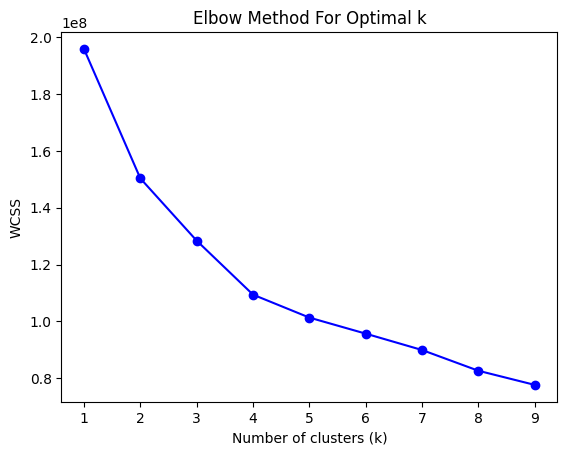

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#Elbow method to find optimal number of clusters
#WCSS (within-cluster sum of squares) used to determine optimal # of clusters
wcss = []

#test different values of k (number of clusters) 1-9
K = range(1, 10)

#for each k, fit the model and calculate WCSS 
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(K, wcss, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')
plt.show()

C:\Users\Acer Nitro 5\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


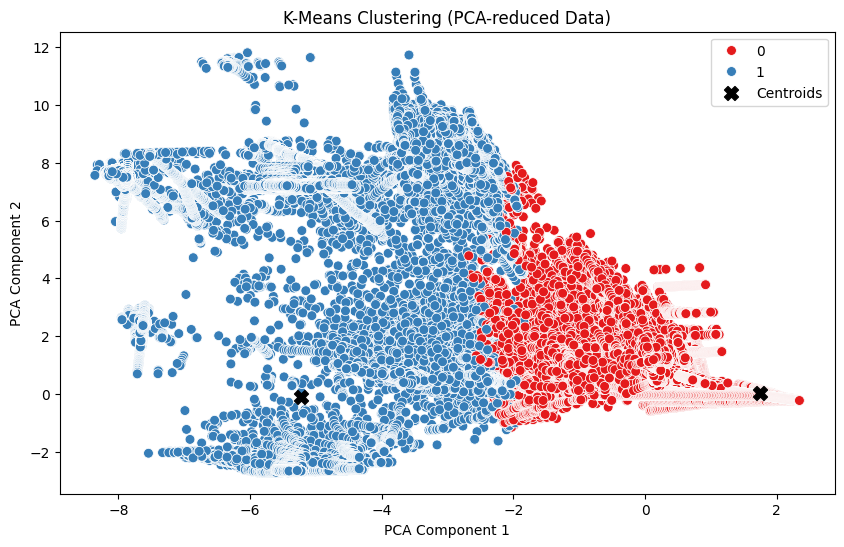

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

#Reduce to 2D w/ PCA (Principal Component Analysis)
#Step 1: Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)  # X_scaled: your normalized data

#Fit KMeans with optimal k
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

#Create scatter plot 
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set1', s=50)

#Plot centroids 
centroids_2d = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=100, c='black', marker='X', label='Centroids')

plt.title("K-Means Clustering (PCA-reduced Data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()
